In [3]:
import pandas as pd
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
import networkx as nx
data = xr.open_dataset("../AQ - Experiments/data/delhi_cpcb_2022.nc")

data

<xarray.Dataset>
Dimensions:    (station: 40, time: 8783)
Coordinates:
  * station    (station) object 'Alipur, Delhi - DPCC' ... 'Wazirpur, Delhi -...
  * time       (time) datetime64[ns] 2022-01-01T00:30:00 ... 2023-01-01T22:23:30
    latitude   (station) float64 ...
    longitude  (station) float64 ...
Data variables: (12/21)
    From Date  (station, time) datetime64[ns] ...
    To Date    (station, time) datetime64[ns] ...
    PM2.5      (station, time) float64 ...
    PM10       (station, time) float64 ...
    NO         (station, time) float64 ...
    NO2        (station, time) float64 ...
    ...         ...
    WD         (station, time) float64 ...
    SR         (station, time) float64 ...
    BP         (station, time) float64 ...
    AT         (station, time) float64 ...
    RF         (station, time) float64 ...
    TOT-RF     (station, time) float64 ...

In [4]:
df = data.to_dataframe()
# df = df["2022-01-01": "2022-12-31"]
df = data.to_dataframe().reset_index()
df = df[df["time"]=="2022-03-01 01:30:00"]
df = df.dropna(subset=["PM2.5"])
df = df.rename(columns={"RH": "relative_humidity", "WS": "wind_speed", "WD": "wind_direction", "SR": "solar_radiation", "BP": "pressure", "AT": "temperature", "RF": "rain_fall", "TOT-RF": "total_rainfall"})

In [5]:
lat_list = [28.815329,28.647622,28.695381,28.4706914,28.7762,28.7256504,28.5512005,28.656756,28.7500499,28.498571,28.5710274,28.655935,28.5627763,28.6811736,28.628624,28.73282,28.58028,28.588333,28.5918245,28.611281,28.636429,28.684678,28.60909,28.570173,28.822836,28.56789,28.6573814,28.530785,28.623763,28.674045,28.639645,28.639645,28.563262,28.732528,28.6514781,28.5504249,28.710508,28.531346,28.672342,28.699793]

In [6]:
df.head()

,station,time,From Date,To Date,PM2.5,PM10,NO,NO2,NOx,NH3,...,relative_humidity,wind_speed,wind_direction,solar_radiation,pressure,temperature,rain_fall,total_rainfall,latitude,longitude
1417,"Alipur, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,70.00,150.0,3.78,43.38,26.15,3.42,...,78.22,NaN,139.97,4.55,993.40,11.43,0.0,0.0,28.815329,77.153010
10200,"Anand Vihar, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,52.50,144.0,11.88,30.62,26.02,15.82,...,68.95,0.30,246.25,8.95,973.65,15.45,NaN,0.0,28.647622,77.315809
18983,"Ashok Vihar, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,79.00,134.0,7.47,67.17,41.80,50.77,...,71.30,0.38,206.90,5.43,987.17,13.82,0.0,0.0,28.695381,77.181665
27766,"Aya Nagar, Delhi - IMD",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,73.94,159.3,22.49,26.28,48.80,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,28.470691,77.109936
36549,"Bawana, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,135.00,245.0,4.80,20.65,25.43,41.45,...,81.62,0.62,22.33,5.70,993.12,12.30,0.0,0.0,28.776200,77.051074


In [7]:
import networkx as nx
import math

# Define the distance threshold for G1 (in kilometers)
distance_threshold_1 = 12

# Create an empty nx graph
G1 = nx.Graph()

# Iterate through each node in the dataset
for i in range(len(df)):
    lat1, lon1 = df.iloc[i]['latitude'], df.iloc[i]['longitude']
    pm = df.iloc[i]['PM2.5']
    
    # Add the current node to the nx graph
    G1.add_node(i, latitude=lat1, longitude=lon1, pm=pm)

    # Iterate through the remaining nodes
    for j in range(i + 1, len(df)):
        lat2, lon2 = df.iloc[j]['latitude'], df.iloc[j]['longitude']
        
        # Calculate the distance between the coordinates using the Haversine formula
        radius = 6371  # Earth's radius in kilometers
        dlat = math.radians(lat2 - lat1)
        dlon = math.radians(lon2 - lon1)
        a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        distance = radius * c
        
        # Check if the distance is below the threshold
        if distance <= distance_threshold_1:
            # Add an edge between the current pair of nodes in the nx graph
            G1.add_edge(i, j)

# Define the distance threshold for G2 (in kilometers)
distance_threshold_2 = 100

# Create an empty nx graph
G2 = nx.Graph()

# Iterate through each node in the dataset
for i in range(len(df)):
    lat1, lon1 = df.iloc[i]['latitude'], df.iloc[i]['longitude']
    pm = df.iloc[i]['PM2.5']
    
    # Add the current node to the nx graph
    G2.add_node(i, latitude=lat1, longitude=lon1, pm=pm)

    # Iterate through the remaining nodes
    for j in range(i + 1, len(df)):
        lat2, lon2 = df.iloc[j]['latitude'], df.iloc[j]['longitude']
        
        # Calculate the distance between the coordinates using the Haversine formula
        radius = 6371  # Earth's radius in kilometers
        dlat = math.radians(lat2 - lat1)
        dlon = math.radians(lon2 - lon1)
        a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        distance = radius * c
        
        # Check if the distance is below the threshold
        if distance <= distance_threshold_2:
            # Add an edge between the current pair of nodes in the nx graph
            G2.add_edge(i, j)

# Now you have the nx graph where nodes represent the data points with latitude and longitude as features, and edges represent nodes within the distance threshold


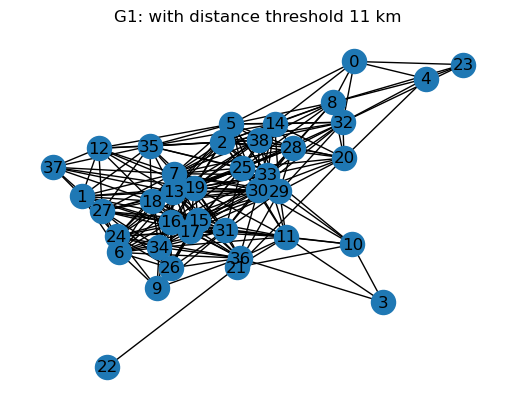

In [8]:
layout1 = nx.spring_layout(G1, k=0.5)

# Draw the graph with the specified layout
plt.figure()  
plt.title("G1: with distance threshold 11 km")
nx.draw(G1, pos=layout1, with_labels=True)
plt.show()

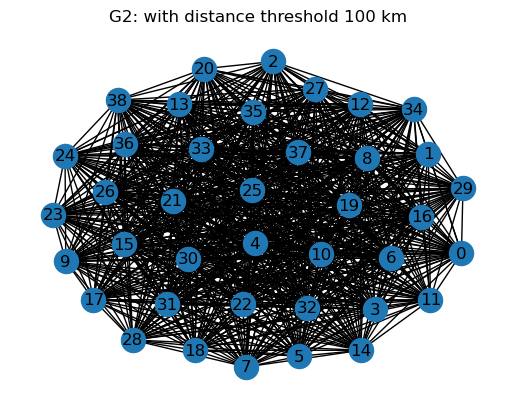

In [9]:
layout2 = nx.spring_layout(G2, k=0.5)

# Draw the graph with the specified layout
plt.figure()
plt.title("G2: with distance threshold 100 km")
nx.draw(G2, pos=layout2, with_labels=True)

In [10]:
import folium
import networkx as nx
from folium.plugins import FastMarkerCluster

# Create a NetworkX graph (G) and calculate node positions (lat_lon_dict)
lat_lon_dict = {}
for node in G1.nodes:
    lat_lon_dict[node] = (G1.nodes[node]['latitude'], G1.nodes[node]['longitude'])

# Create a Folium map centered on Delhi
m = folium.Map(location=[28.7041, 77.1025], zoom_start=10)

# Create a MarkerCluster layer for better performance
marker_cluster = FastMarkerCluster(data=list(lat_lon_dict.values()))
m.add_child(marker_cluster)

# Iterate over the edges and add them to the map as lines
for u, v in G1.edges:
    lat1, lon1 = lat_lon_dict[u]
    lat2, lon2 = lat_lon_dict[v]
    folium.PolyLine([(lat1, lon1), (lat2, lon2)], color='gray', weight=1).add_to(m)

# Iterate over the nodes and add them to the map as markers
for node, (lat, lon) in lat_lon_dict.items():
    folium.CircleMarker(location=(lat, lon), radius=5, color='blue', fill=True, fill_color='blue').add_to(m)

# Display the map
m


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv

#G1
node_features = [(G1.nodes[node]['latitude'], G1.nodes[node]['longitude']) for node in G1.nodes]
edge_index = torch.tensor(list(G1.edges)).t().contiguous()
y = torch.tensor([G1.nodes[node]['pm'] for node in G1.nodes], dtype=torch.float).view(-1, 1)
sorted_nodes = sorted(G1.nodes(), key=lambda node: G1.nodes[node]['latitude'])

# Divide train and test masks based on the sorted latitudes
train_mask = torch.zeros(y.size(0), dtype=torch.bool)
test_mask = torch.zeros(y.size(0), dtype=torch.bool)

for i, node in enumerate(G1.nodes):
    lat = G1.nodes[node]['latitude']
    if lat in lat_list[:25]:
        train_mask[i] = True
    else:
        test_mask[i] = True


data1 = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, y=y,train_mask=train_mask, test_mask=test_mask)

#G2
node_features = [(G2.nodes[node]['latitude'], G2.nodes[node]['longitude']) for node in G2.nodes]
edge_index = torch.tensor(list(G2.edges)).t().contiguous()
y = torch.tensor([G2.nodes[node]['pm'] for node in G2.nodes], dtype=torch.float).view(-1, 1)
sorted_nodes = sorted(G2.nodes(), key=lambda node: G2.nodes[node]['latitude'])

# Divide train and test masks based on the sorted latitudes
train_mask = torch.zeros(y.size(0), dtype=torch.bool)
test_mask = torch.zeros(y.size(0), dtype=torch.bool)

for i, node in enumerate(G2.nodes):
    lat = G2.nodes[node]['latitude']
    if lat in lat_list[:25]:
        train_mask[i] = True
    else:
        test_mask[i] = True


data2 = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, y=y,train_mask=train_mask, test_mask=test_mask)

In [13]:
A1 = torch.tensor(nx.adjacency_matrix(G1).todense(), dtype=torch.float)
A2 = torch.tensor(nx.adjacency_matrix(G2).todense(), dtype=torch.float)

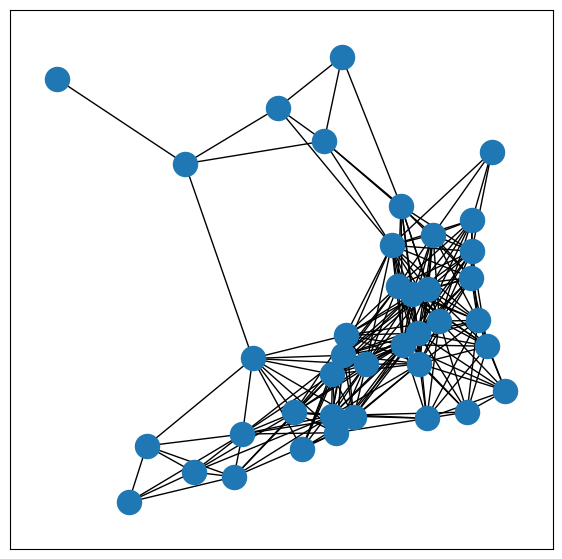

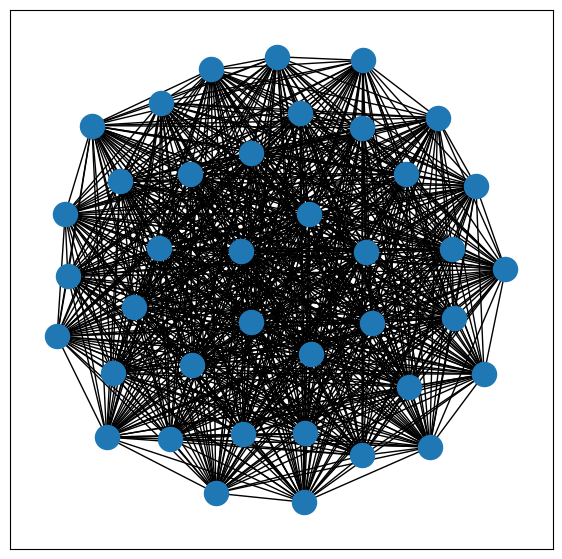

In [14]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,)
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()
    
G1 = to_networkx(data1, to_undirected=True)
visualize_graph(G1, color=data1.y)

G2 = to_networkx(data2, to_undirected=True)
visualize_graph(G2, color=data2.y)

In [8]:
import networkx as nx
G = nx.erdos_renyi_graph(3, 1)

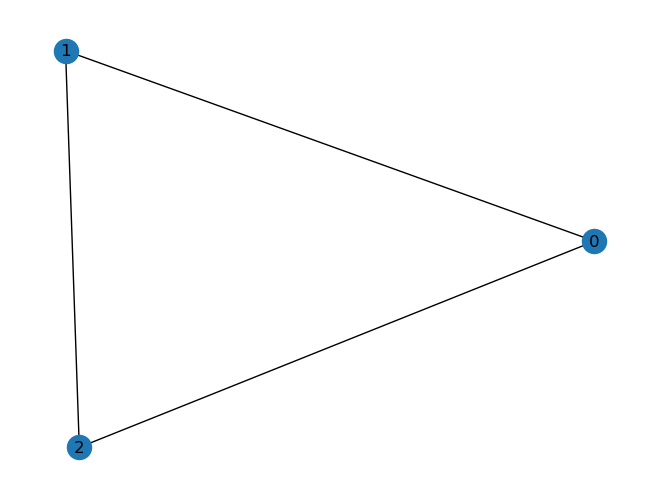

In [9]:
nx.draw(G, with_labels=True)

In [10]:
import torch
adj = nx.adjacency_matrix(G).todense()
adj = torch.tensor(adj)

In [11]:
edge_index = torch.tensor(list(G.edges)).t().contiguous()

In [12]:
edge_index.T

tensor([[0, 1],
        [0, 2],
        [1, 2]])

In [13]:
node_features = torch.rand(3,2)

In [14]:
node_features

tensor([[0.6598, 0.4570],
        [0.4685, 0.9004],
        [0.0869, 0.7473]])

In [15]:
# from torch_geometric.nn import DenseGCNConv

In [16]:
# import torch.nn as nn
# import torch.nn.functional as F
# from torch_geometric.data import Data, Dataset

In [17]:
# dataset = Data(x=node_features, edge_index=edge_index)

In [18]:
# dataset

In [19]:
# from torch_geometric.nn import GCNConv

In [20]:
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = Parameter(torch.Tensor(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=x, norm=norm)

        # Step 6: Apply a final bias vector.
        out += self.bias

        return out

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

In [21]:
conv1 = GCNConv(2, 3)
conv1(node_features, edge_index)

tensor([[ 0.0575, -0.5779, -0.1665],
        [ 0.0369, -0.7042, -0.3115],
        [ 0.0134, -0.6721, -0.3688]], grad_fn=<AddBackward0>)

In [49]:
input = torch.tensor([1, 2, 3, 4, 5])
index = torch.tensor([0, 1, 3, 3, 4])
src = torch.tensor([10, 20, 30, 40, 50])
output = torch.scatter_add(input, dim=0, index=index, src=src)
output

tensor([11, 22,  3, 74, 55])

In [60]:
import torch
import networkx as nx
from torch.nn import init

class GCNConv(torch.nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GCNConv, self).__init__()
        self.weight = torch.nn.Parameter(torch.Tensor(in_features, out_features))
        init.xavier_uniform_(self.weight)
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_features))
        else:
            self.bias = None

    def forward(self, x, edge_index):
        """
        x: node features
        edge_index: edge indices
        """
        # Compute the messages.
        messages = torch.matmul(x[edge_index[0]], self.weight)

        # Update the embeddings.
        x = torch.scatter_add(x, dim=0, index=edge_index[1].unsqueeze(0), src=messages)

        # Add the bias.
        if self.bias is not None:
            x = x + self.bias

        return x


# Create a graph.
graph = nx.Graph()
graph.add_nodes_from(range(10))
graph.add_edges_from([(0, 1), (0, 2), (1, 3), (1, 4), (2, 5), (2, 6), (3, 7), (3, 8), (4, 9), (4, 10), (3, 4)])

# Create the GCNConv layer.
layer = GCNConv(10, 5)

# Get the node features.
x = torch.randn(10, 10)

# Compute the embeddings.
embeddings = layer(x, torch.tensor(list(graph.edges)).t().contiguous())

# Print the embeddings.
print(embeddings)


RuntimeError: Expected index [1, 11] to be smaller than self [10, 10] apart from dimension 0 and to be smaller size than src [11, 5]

In [40]:
from torch_geometric.nn import DenseGCNConv
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.conv1 = DenseGCNConv(input_dim, 16)
        self.conv2 = DenseGCNConv(16, 10)
        # self.conv3 = GATConv(10, 10)
        self.linear1 = nn.Linear(10, 10)
        self.linear2 = nn.Linear(10, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        # x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x


NameError: name 'nn' is not defined

In [16]:
import random
seed = 42
random.seed(seed)
torch.manual_seed(seed)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1 = RegressionModel(input_dim=2).to(device)
model2 = RegressionModel(input_dim=2).to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [17]:
model2(data2.x, A1).squeeze().shape

torch.Size([39])

In [18]:
train_rmse_list1 = []
test_rmse_list1 = []

train_rmse_list2 = []
test_rmse_list2 = []

In [19]:
from tqdm import tqdm

#Training Loop for G1
# for epoch in tqdm(range(2500)):
#     optimizer.zero_grad()
#     out = model1(data1.x, A1).squeeze()
#     print(out.shape)
#     loss = criterion(out.squeeze(), data1.y.squeeze())
#     loss.backward()
#     optimizer.step()
#     if(epoch%100==0):
#         model1.eval()
#         with torch.no_grad():
#             out = model1(data1.x.to(device), data1.edge_index.to(device))  # Predicted PM values
#             train_rmse = torch.sqrt(torch.mean((out[data1.train_mask].squeeze() - data1.y[data1.train_mask].squeeze())**2))
#             test_rmse = torch.sqrt(torch.mean((out[data1.test_mask].squeeze() - data1.y[data1.test_mask].squeeze())**2))
#             train_rmse_list1.append(train_rmse.item())
#             test_rmse_list1.append(test_rmse.item())
#         model1.train()

optimizer = torch.optim.Adam(model2.parameters(), lr=0.01)
criterion = nn.MSELoss()
# Training Loop for G2
for epoch in tqdm(range(2500)):
    optimizer.zero_grad()
    out = model2(data2.x.to(device), A2)
    loss = criterion(out.squeeze(), data2.y.squeeze())
    loss.backward()
    optimizer.step()
    if(epoch%100==0):
        model2.eval()
        with torch.no_grad():
            out = model2(data2.x.to(device), A2)  # Predicted PM values
            train_rmse = torch.sqrt(torch.mean((out.squeeze() - data2.y.squeeze())**2))
            # test_rmse = torch.sqrt(torch.mean((out[data2.test_mask].squeeze() - data2.y[data2.test_mask].squeeze())**2))
            train_rmse_list2.append(train_rmse.item())
            # test_rmse_list2.append(test_rmse.item())
        model2.train()

100%|██████████| 2500/2500 [00:01<00:00, 1704.22it/s]


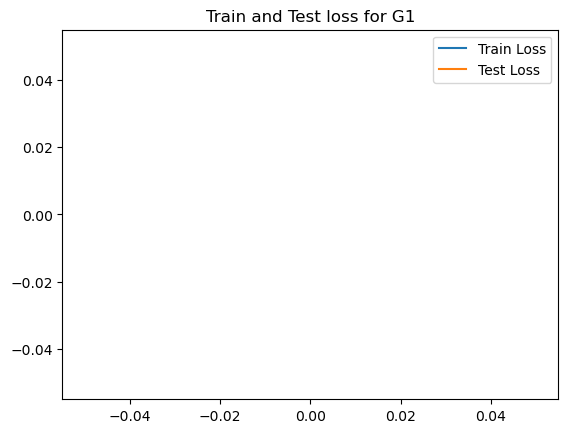

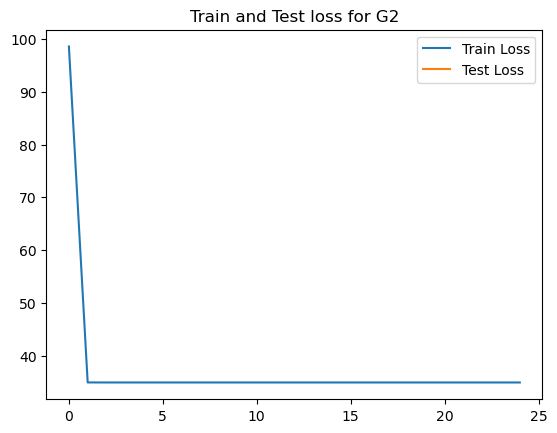

In [20]:
import matplotlib.pyplot as plt

# Assuming you have train_loss_list and test_loss_list as lists containing the respective losses

# Plotting train loss
plt.plot(range(len(train_rmse_list1)), train_rmse_list1, label='Train Loss')

# Plotting test loss
plt.plot(range(len(test_rmse_list1)), test_rmse_list1, label='Test Loss')
plt.title("Train and Test loss for G1")
plt.legend()
plt.show()


# Plotting train loss
plt.plot(range(len(train_rmse_list2)), train_rmse_list2, label='Train Loss')

# Plotting test loss
plt.plot(range(len(test_rmse_list2)), test_rmse_list2, label='Test Loss')
plt.title("Train and Test loss for G2")
plt.legend()
plt.show()

In [21]:
# model1.eval()
# with torch.no_grad():
#     out = model1(data1.x.to(device), data1.edge_index.to(device))  # Predicted PM values
#     train_rmse = torch.sqrt(torch.mean((out[data1.train_mask].squeeze() - data1.y[data1.train_mask].squeeze())**2))
#     test_rmse = torch.sqrt(torch.mean((out[data1.test_mask].squeeze() - data1.y[data1.test_mask].squeeze())**2))
#     print("G1")
#     print(f"GNN train rmse:{train_rmse}")
#     print(f"GNN test rmse: {test_rmse}")

model2.eval()
with torch.no_grad():
    out = model2(data2.x.to(device), A2)  # Predicted PM values
    train_rmse = torch.sqrt(torch.mean((out.squeeze() - data2.y.squeeze())**2))
    # test_rmse = torch.sqrt(torch.mean((out[data2.test_mask].squeeze() - data2.y[data2.test_mask].squeeze())**2))
    print("\nG2")
    print(f"GNN train rmse:{train_rmse}")
    # print(f"GNN test rmse: {test_rmse}")


G2
GNN train rmse:34.89106750488281


In [22]:
len(data1.x[data1.train_mask].numpy())
len(data2.x[data2.train_mask].numpy())

24

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

#Step 1: Prepare the Data
X_train = data1.x[data1.train_mask].numpy()
y_train = data1.y[data1.train_mask].numpy().reshape(-1)
X_test = data1.x[data1.test_mask].numpy()
y_test = data1.y[data1.test_mask].numpy().reshape(-1)

# Step 2: Initialize and train models
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model.fit(X_train, y_train)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

k_range = list(range(1, 10))
param_grid = dict(n_neighbors=k_range)
knn_model = KNeighborsRegressor()
grid = GridSearchCV(knn_model, param_grid, cv=10, scoring='neg_root_mean_squared_error', return_train_score=False,verbose=1)
grid_search=grid.fit(X_train, y_train)

# Step 3: Make Predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

y_train_pred_knn = grid_search.predict(X_train)
y_test_pred_knn = grid_search.predict(X_test)

# Step 4: Evaluate the model
train_rmse_rf = torch.sqrt(torch.mean((torch.tensor(y_train_pred_rf) - data1.y[data1.train_mask])**2))
test_rmse_rf = torch.sqrt(torch.mean((torch.tensor(y_test_pred_rf) - data1.y[data1.test_mask])**2))

train_rmse_lr = torch.sqrt(torch.mean((torch.tensor(y_train_pred_lr) - data1.y[data1.train_mask])**2))
test_rmse_lr = torch.sqrt(torch.mean((torch.tensor(y_test_pred_lr) - data1.y[data1.test_mask])**2))

train_rmse_knn = torch.sqrt(torch.mean((torch.tensor(y_train_pred_knn) - data1.y[data1.train_mask])**2))
test_rmse_knn = torch.sqrt(torch.mean((torch.tensor(y_test_pred_knn) - data1.y[data1.test_mask])**2))


print('Random Forest')
print('Train RMSE:', train_rmse_rf.item())
print('Test RMSE:', test_rmse_rf.item())


print("\nLinear Regression")
print('Train RMSE:', train_rmse_lr.item())
print('Test RMSE:', test_rmse_lr.item())

print("\nKNN")
print('Train RMSE:', train_rmse_knn.item())
print('Test RMSE:', test_rmse_knn.item())

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
Train RMSE: 46.38294396484412
Test RMSE: 28.07512041353537

Linear Regression
Train RMSE: 40.254634857177734
Test RMSE: 27.990694046020508

KNN
Train RMSE: 40.29072189331055
Test RMSE: 28.46442985534668


In [24]:
len(y_test_pred_rf), len(y_test_pred_lr), len(y_test_pred_knn)

(15, 15, 15)

In [25]:
y_test = data1.y[data1.test_mask].squeeze().cpu().numpy()
y_test

array([124.67,  93.25,  75.  ,  55.  ,  58.5 ,  22.41, 113.  , 103.  ,
        59.72,  51.62,  94.  ,  63.  ,  83.  ,  90.  ,  77.5 ],
      dtype=float32)

In [26]:
model2(data2.x.to(device), A2).squeeze().detach().numpy().shape

(39,)

In [27]:
data2.x[:,0].shape

torch.Size([39])

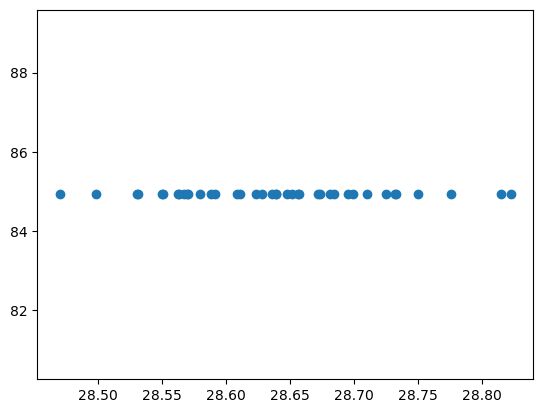

In [28]:
plt.scatter(data2.x[:,0],model2(data2.x.to(device), A2).squeeze().detach().numpy())

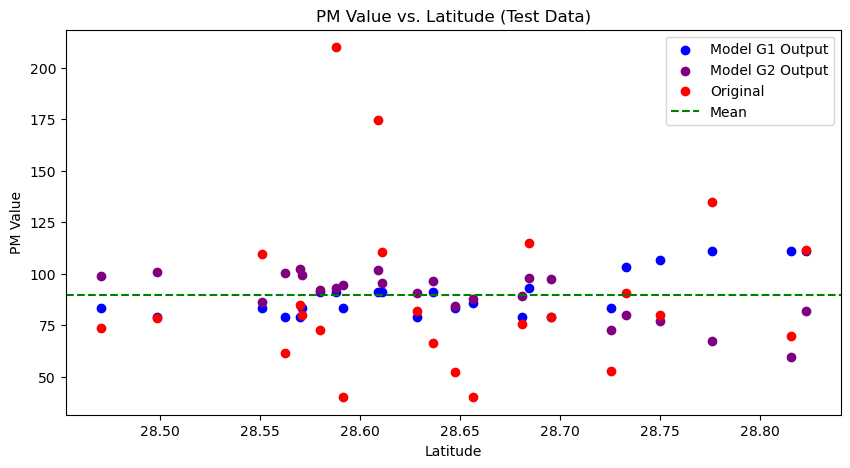

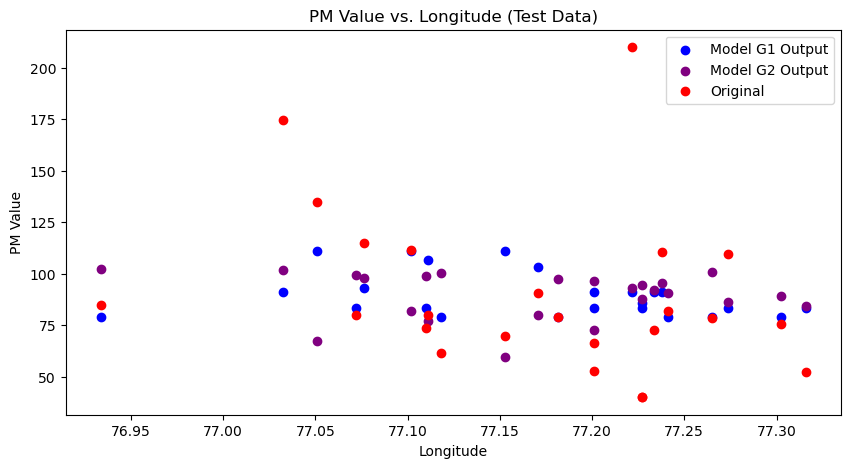

In [58]:
import matplotlib.pyplot as plt

# Get the output of the model and original y values for test data
with torch.no_grad():
    out_test1 = model1(data1.x.to(device), data1.edge_index.to(device))[data1.train_mask].squeeze()
y_test = data1.y[data1.train_mask].squeeze().cpu().numpy()

with torch.no_grad():
    out_test2 = model2(data2.x.to(device), data2.edge_index.to(device))[data2.train_mask].squeeze()

# Get the latitude and longitude for test data
lat_test = data1.x[data1.train_mask][:, 0].cpu().numpy()
lon_test = data1.x[data1.train_mask][:, 1].cpu().numpy()
train_mean = torch.mean(data1.y[data1.train_mask])

# Plot the model output against latitude and longitude
plt.figure(figsize=(10, 5))
plt.scatter(lat_test, out_test1.cpu().numpy(), c='b', label='Model G1 Output')
plt.scatter(lat_test, out_test2.cpu().numpy(), c='purple', label='Model G2 Output')
plt.scatter(lat_test, y_test, c='r', label='Original')
# plt.scatter(lat_test, y_test_pred_rf, c='orange', label='RF Model Output')
# plt.scatter(lat_test, y_test_pred_lr, c = 'black' , label = 'Linear Regression Model Output')
# plt.scatter(lat_test, y_test_pred_knn, c = 'lightblue', label = 'KNN Model Output')
plt.axhline(train_mean, c='g', linestyle='--', label='Mean')
plt.xlabel('Latitude')
plt.ylabel('PM Value')
plt.title('PM Value vs. Latitude (Test Data)')
plt.legend()
plt.show()


# Plot the model output against latitude and longitude
plt.figure(figsize=(10, 5))
plt.scatter(lon_test, out_test1.cpu().numpy(), c='b', label='Model G1 Output')
plt.scatter(lon_test, out_test2.cpu().numpy(), c='purple', label='Model G2 Output')
plt.scatter(lon_test, y_test, c='r', label='Original')
# plt.scatter(lon_test, y_test_pred_rf, c='orange', label='RF Model Output')
# plt.scatter(lon_test, y_test_pred_lr, c = 'black' , label = 'Linear Regression Model Output')
# plt.scatter(lon_test, y_test_pred_knn, c = 'lightblue', label = 'KNN Model Output')
# plt.axhline(train_mean, c='g', linestyle='--', label='Mean')
plt.xlabel('Longitude')
plt.ylabel('PM Value')
plt.title('PM Value vs. Longitude (Test Data)')
plt.legend()
plt.show()



In [22]:
train_mean = torch.mean(data1.y[data1.train_mask])
torch.sqrt(torch.mean((train_mean - data1.y[data1.test_mask].squeeze())**2))

tensor(28.3805)